In [51]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

gpu = torch.cuda.current_device()
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650 with Max-Q Design'

In [52]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [53]:
# hyper parameters
input_size = 28 * 28 # image is of 28x28 pixel dimensions
hidden_size = 100
num_classes = 10 # dataset has 10 classes: digits 0 - 9
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [54]:
# import mnist dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data/mnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./data/mnist",
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

examples = iter(train_loader)
samples, labels = examples.__next__()

print(samples.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


`print(samples.shape)`: `torch.Size([100, 1, 28, 28])`

1. 100 -> 100 samples per batch
2. 1 -> only 1 channel, no coloured
3. 28x28 -> actual image array

`print(labels.shape)`: `torch.Size([100])`
for each class label we have 1 value

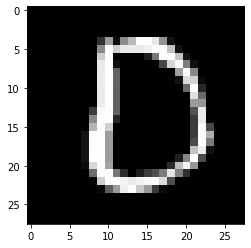

In [55]:
# plotting first sample
plt.imshow(samples[0][0], cmap="gray")

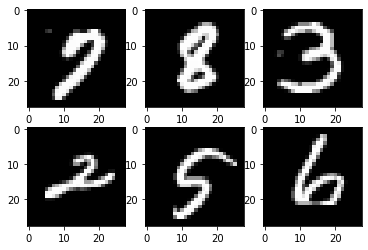

In [56]:
# plotting a group of images
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(samples[i][0], cmap="gray")

In [57]:
class MyNeuralNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(MyNeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = MyNeuralNetwork(input_size, hidden_size, num_classes)
model.to(device)

MyNeuralNetwork(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (l2): Linear(in_features=100, out_features=10, bias=True)
)

In [58]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [59]:
n_total_steps = len(train_loader)

# do training loops
for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(train_loader):

            # images are in shape [100, 1, 28, 28]
            # we have to reshape it to n x 28*28
            images = images.reshape(-1, 28 * 28)

            images = images.to(device)
            labels = labels.to(device)

            # forward
            pred_labels = model.forward(images)

            # loss
            loss = criterion(pred_labels, labels)

            # backward
            optimizer.zero_grad() # putting this above or below is not a problem
            loss.backward()
            optimizer.step()

            if i % 99 == 0:
                print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_total_steps}, loss: {loss.item():.4f}")

epoch: 1/2, step: 1/600, loss: 2.2930
epoch: 1/2, step: 100/600, loss: 0.3826
epoch: 1/2, step: 199/600, loss: 0.3667
epoch: 1/2, step: 298/600, loss: 0.3486
epoch: 1/2, step: 397/600, loss: 0.1842
epoch: 1/2, step: 496/600, loss: 0.2944
epoch: 1/2, step: 595/600, loss: 0.1691
epoch: 2/2, step: 1/600, loss: 0.1667
epoch: 2/2, step: 100/600, loss: 0.2887
epoch: 2/2, step: 199/600, loss: 0.0706
epoch: 2/2, step: 298/600, loss: 0.2210
epoch: 2/2, step: 397/600, loss: 0.1947
epoch: 2/2, step: 496/600, loss: 0.2284
epoch: 2/2, step: 595/600, loss: 0.1697


In [60]:
# testing
with torch.no_grad():

    n_correct = 0
    n_samples = 0

    for images, labels in test_loader:

        # reshape -> same as above
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        pred_labels = model(images)

        # pred_labels would be probabilities
        # get classes out of those prob.
        _, pred_labels = torch.max(pred_labels, dim=1)

        n_samples += labels.shape[0]
        n_correct = (pred_labels == labels).sum().item()

    accuracy = 100 * n_correct / n_samples
    print(f"accuracy: {accuracy}")


accuracy: 0.92
